# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
Apply various data cleaning, feature engineering, and modeling techniques to a used car dataset to predict car prices. Provide visualizations to illustrate relationships in the data. 
Explain to used car dealers how they can leverage these insights to optimize their pricing strategies.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:
1. Explore the data set to understand the columns and their data types.
2. Limit data range to remove outliers.
3. Check for missing values and duplicates. Handle them appropriately.
4. Convert or map (where possible) to numeric values for better numeric analysis.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [44]:
# Import necessary libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [61]:
df = pd.read_csv('../data/vehicles.csv')

In [62]:
# Data filtering and cleaning
df = df.drop(columns=['id', 'VIN'])
df = df[(df['price'] >= 1000) & (df['price'] <= 150000)]
df = df[(df['year'] >= 1990) & (df['year'] <= 2022)]
df = df[(df['odometer'] >= 0) & (df['odometer'] <= 400000)]


df['paint_color'] = df['paint_color'].fillna('unknown')
df['condition'] = df['condition'].fillna('unknown')
df['odometer'] = df['odometer'].fillna(df['odometer'].median())
df['year'] = df['year'].fillna(df['year'].median())

# Map condition to numeric
df['condition_num'] = df['condition'].replace({
    'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5, 'unknonwn': np.nan
    })

df['cylinders'] = df['cylinders'].astype(str).str.extract('(\d+)').astype(float)
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].median())

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Examples of duplicate rows
print("\nExample of duplicate rows:")
print(df[df.duplicated(keep='first')].head())

# Get the percentage of duplicates
duplicate_percentage = (duplicate_count / len(df)) * 100
print(f"\nPercentage of duplicate rows: {duplicate_percentage:.2f}%")

df_clean = df.drop_duplicates().reset_index(drop=True)

duplicate_count = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
df_clean = df_clean.dropna()
df_clean.head()

Number of duplicate rows: 44451

Example of duplicate rows:
         region  price    year manufacturer      model condition  cylinders  \
422  birmingham   3399  2006.0        buick   lacrosse   unknown        6.0   
425  birmingham   3900  2009.0      hyundai    elantra   unknown        4.0   
429  birmingham   3300  1999.0     chrysler       300m   unknown        6.0   
456  birmingham   3999  2003.0     infiniti  g35 sedan   unknown        6.0   
464  birmingham   2550  2004.0     cadillac        srx   unknown        6.0   

    fuel  odometer title_status transmission drive size   type paint_color  \
422  gas  160218.0        clean    automatic   fwd  NaN  sedan        blue   
425  gas  162005.0        clean    automatic   rwd  NaN  sedan       white   
429  gas  162026.0        clean    automatic   fwd  NaN  sedan     unknown   
456  gas  233830.0        clean    automatic   rwd  NaN  sedan     unknown   
464  gas  224105.0        clean    automatic   rwd  NaN    SUV       white 

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,condition_num
4,auburn,15000,2013.0,ford,f-150 xlt,excellent,6.0,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,3
27,auburn,19900,2004.0,ford,f250 super duty,good,8.0,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al,2
31,auburn,14000,2012.0,honda,odyssey,excellent,6.0,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al,3
37,auburn,22500,2001.0,ford,f450,good,8.0,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al,2
45,auburn,15000,2017.0,dodge,charger rt 4dr sedan,excellent,8.0,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al,3


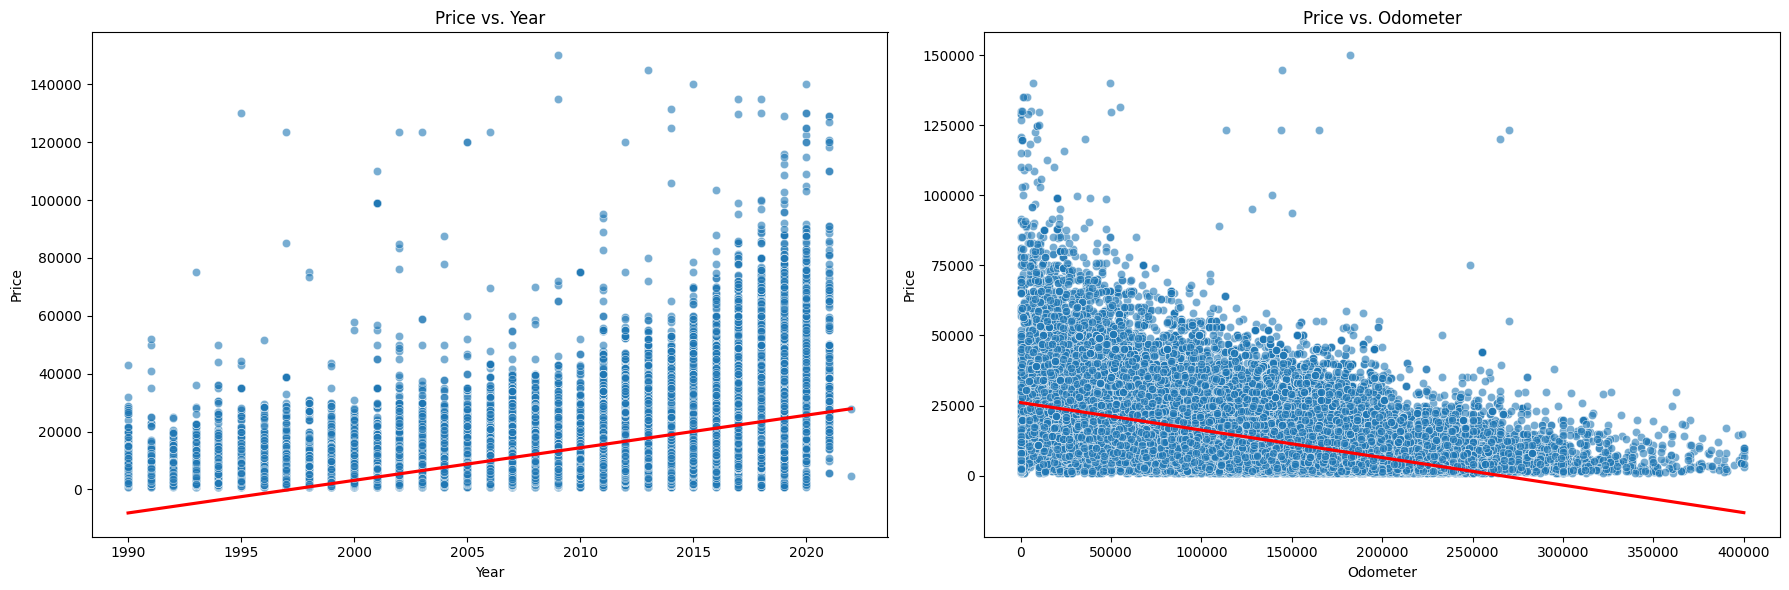

In [52]:
# Set up the matplotlib figure and axes for numerical vs numerical scatter plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot of Price vs Year
sns.scatterplot(data=df_clean, x='year', y='price', ax=axes[0], alpha=0.6)
sns.regplot(data=df_clean, x='year', y='price', scatter=False, color='red', ax=axes[0])
axes[0].set_title('Price vs. Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price')

# Scatter plot of Price vs Odometer
sns.scatterplot(data=df_clean, x='odometer', y='price', ax=axes[1], alpha=0.6)
sns.regplot(data=df_clean, x='odometer', y='price', scatter=False, color='red', ax=axes[1])
axes[1].set_title('Price vs. Odometer')
axes[1].set_xlabel('Odometer')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

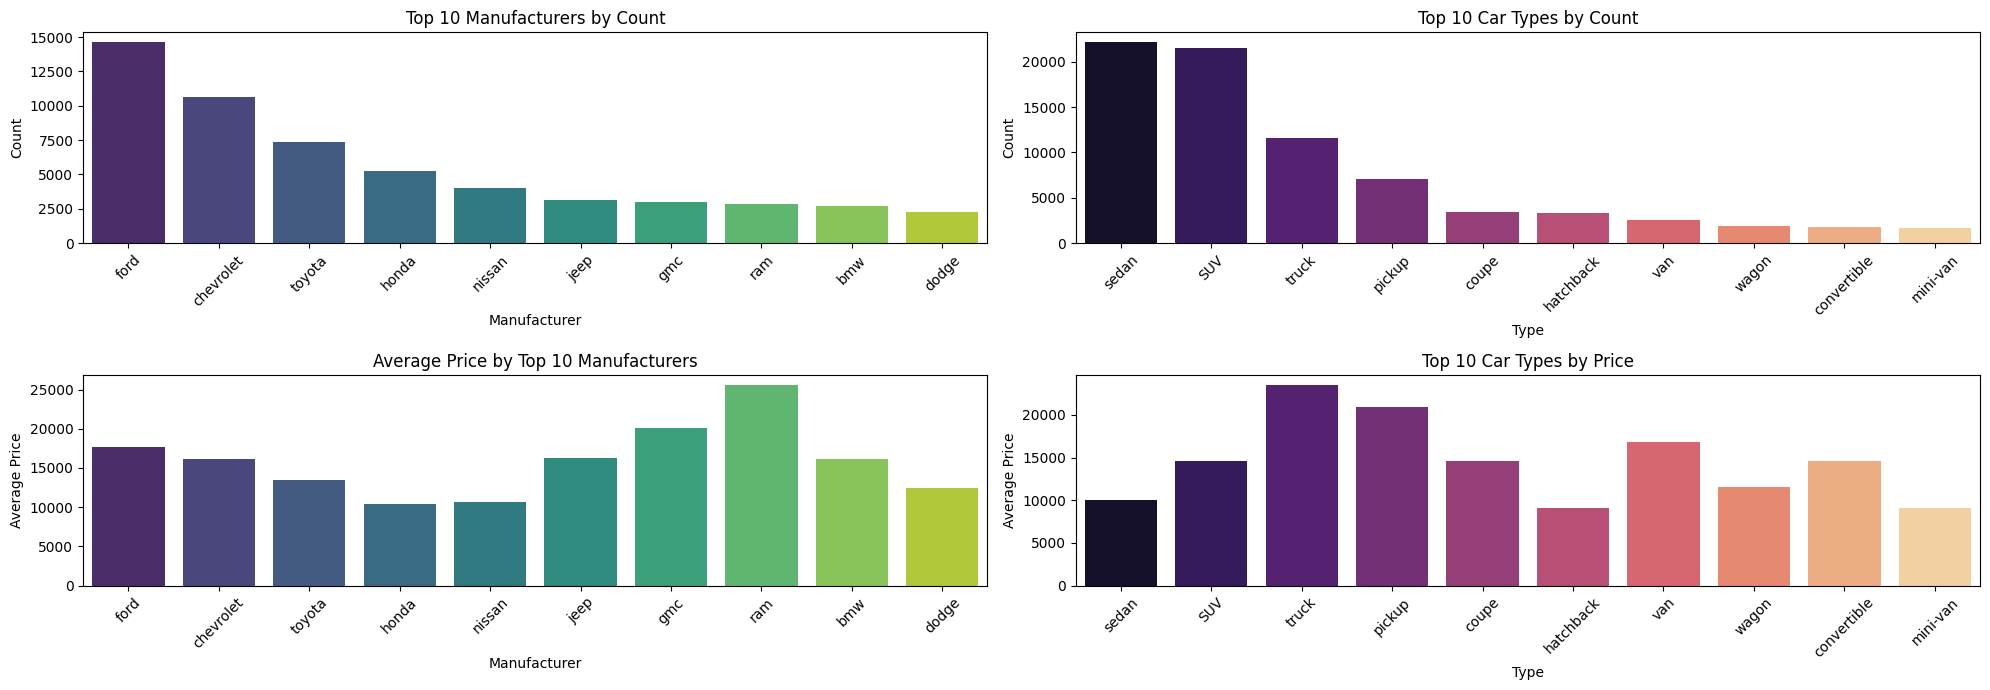

In [57]:
# Set up the matplotlib figure and axes for categorical features
fig, axes = plt.subplots(2, 2, figsize=(20, 7))

# Plot value counts for 'manufacturer'
manufacturer_counts = df_clean['manufacturer'].value_counts().head(10)
sns.barplot(x=manufacturer_counts.index, y=manufacturer_counts.values, hue=manufacturer_counts.index, ax=axes[0, 0], palette='viridis', legend=False)
axes[0, 0].set_title('Top 10 Manufacturers by Count')
axes[0, 0].set_xlabel('Manufacturer')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot value counts for 'type'
type_counts = df_clean['type'].value_counts().head(10)
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index, ax=axes[0, 1], palette='magma', legend=False)
axes[0, 1].set_title('Top 10 Car Types by Count')
axes[0, 1].set_xlabel('Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

manufacturer_prices = df_clean.groupby('manufacturer')['price'].mean().loc[manufacturer_counts.index]
sns.barplot(x=manufacturer_prices.index, y=manufacturer_prices.values, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Average Price by Top 10 Manufacturers')
axes[1, 0].set_xlabel('Manufacturer')
axes[1, 0].set_ylabel('Average Price')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot value counts for 'type'
type_prices = df_clean.groupby('type')['price'].mean().loc[type_counts.index]
sns.barplot(x=type_prices.index, y=type_prices.values, hue=type_prices.index, ax=axes[1, 1], palette='magma', legend=False)
axes[1, 1].set_title('Top 10 Car Types by Price')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Average Price')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

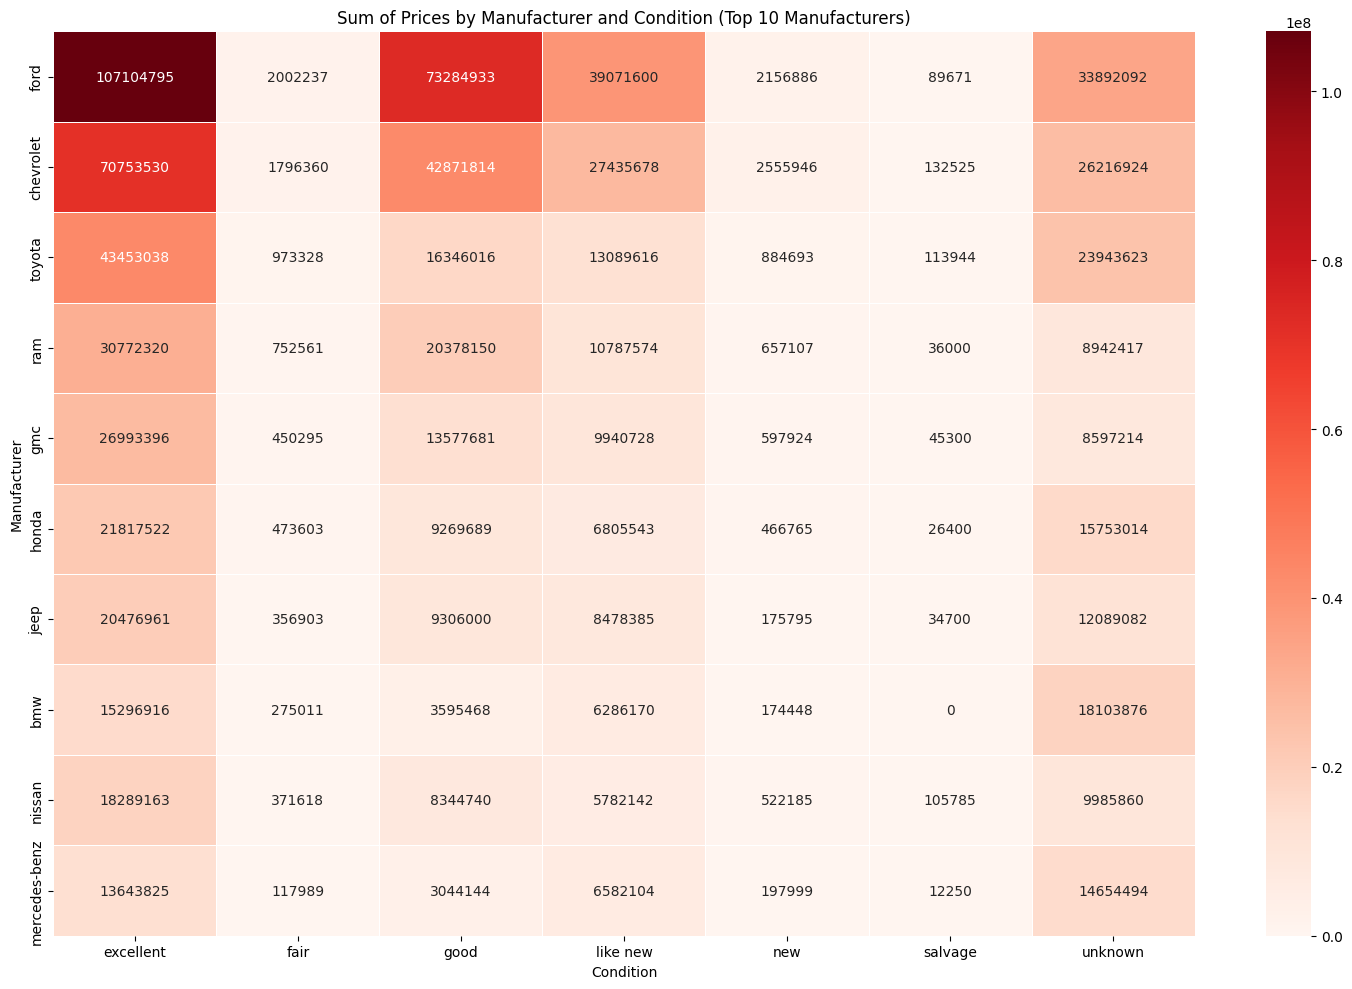

In [59]:
# Group by manufacturer and condition and sum the prices
manufacturer_condition_price_sum = df_clean.groupby(['manufacturer', 'condition'])['price'].sum().unstack(fill_value=0)

# Select top manufacturers for better readability, e.g., top 10 by total price
top_manufacturers_by_price = manufacturer_condition_price_sum.sum(axis=1).nlargest(10).index
manufacturer_condition_price_sum_filtered = manufacturer_condition_price_sum.loc[top_manufacturers_by_price]

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(manufacturer_condition_price_sum_filtered, annot=True, fmt='.0f', cmap='Reds', linewidths=.5)
plt.title('Sum of Prices by Manufacturer and Condition (Top 10 Manufacturers)')
plt.xlabel('Condition')
plt.ylabel('Manufacturer')
plt.tight_layout()
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [63]:
# Drop certain columns to reduce dimensionality and execution time (~30 minutes to seconds)
df_clean = df_clean.drop(columns=['fuel', 'region', 'paint_color', 'model', 'condition', 'transmission'])
df_clean.head()

df_encoded = pd.get_dummies(df_clean, drop_first=True)

scholar = StandardScaler()
scaled = scholar.fit_transform(df_encoded)
scaled_df = pd.DataFrame(scaled, columns=df_encoded.columns)

# Ensure X and y are defined (features and target)
y = scaled_df['price']
X = scaled_df.drop(columns=['price'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
linear_model_full = LinearRegression()
linear_model_full.fit(X_train, y_train)

# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

# Get coefficients from Linear Regression model
linear_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Linear_Coefficient': linear_model_full.coef_
}).sort_values(by='Linear_Coefficient', ascending=False)
linear_train_mse = mean_squared_error(y_train, linear_model_full.predict(X_train))
linear_test_mse = mean_squared_error(y_test, linear_model_full.predict(X_test))

# Get coefficients from Lasso Regression model
lasso_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Lasso_Coefficient': lasso_model.coef_
}).sort_values(by='Lasso_Coefficient', ascending=False)
lasso_train_mse = mean_squared_error(y_train, lasso_model.predict(X_train))
lasso_test_mse = mean_squared_error(y_test, lasso_model.predict(X_test))

# Get coefficients from Ridge Regression model
ridge_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Ridge_Coefficient': ridge_model.coef_
}).sort_values(by='Ridge_Coefficient', ascending=False)
ridge_train_mse = mean_squared_error(y_train, ridge_model.predict(X_train))
ridge_test_mse = mean_squared_error(y_test, ridge_model.predict(X_test))

print("\n--- Linear Regression Coefficients ---")
print(linear_coefficients.head(10))
print("\nLinear Train MSE:", linear_train_mse)
print("Linear Test MSE:", linear_test_mse)

print("\n--- Lasso Regression Coefficients (Top 10 Non-Zero) ---")
print(lasso_coefficients[lasso_coefficients['Lasso_Coefficient'] != 0].head(10))
print("\nLasso Train MSE:", lasso_train_mse)
print("Lasso Test MSE:", lasso_test_mse)
print("\n--- Ridge Regression Coefficients ---")
print(ridge_coefficients.head(10))
print("\nRidge Train MSE:", ridge_train_mse)
print("Ridge Test MSE:", ridge_test_mse)


--- Linear Regression Coefficients ---
                   Feature  Linear_Coefficient
0                     year            0.427802
61              type_truck            0.219557
1                cylinders            0.188067
59             type_pickup            0.123724
116        condition_num_3            0.099458
117        condition_num_4            0.096316
119  condition_num_unknown            0.094626
12    manufacturer_ferrari            0.075258
115        condition_num_2            0.067413
54              type_coupe            0.062817

Linear Train MSE: 0.34086831522535477
Linear Test MSE: 0.340817884723699

--- Lasso Regression Coefficients (Top 10 Non-Zero) ---
        Feature  Lasso_Coefficient
0          year           0.365401
1     cylinders           0.164239
61   type_truck           0.108292
59  type_pickup           0.014052
60   type_sedan          -0.027513
47    drive_fwd          -0.137109
2      odometer          -0.237983

Lasso Train MSE: 0.441818150760

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

1. All 3 models (Linear, Lasso, Ridge) performed similarly with slight variations in MSE.
2. Based on the coefficients, certain features consistently showed higher importance across models, indicating their strong influence on car prices. We can advise used car dealers to focus on these key features when pricing their vehicles.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

**Recommendations to our valued Dealers:**
**1. Year (0.427802):** This has the strongest positive impact, indicating that newer cars (higher 'year' value) command significantly higher prices. This aligns with common understanding as newer cars typically have lower mileage, better technology, and less wear and tear.
**2. Odometer (-0.308912):** This has the strongest negative impact, meaning higher mileage (odometer reading) leads to considerably lower car prices. This is a fundamental depreciation factor for used cars.
**3. Type_Truck (0.219557) & Type_Pickup (0.123724):** These vehicle types show a substantial positive influence on price. Trucks and pickups tend to be more expensive due to their utility, durability, and often higher original purchase price.
**4. Cylinders (0.188067):** A higher number of cylinders is associated with a higher price, likely due to larger engines often found in more powerful or luxurious vehicles.
**5. Drive_FWD (-0.162803):** Front-wheel drive (FWD) cars are associated with a negative impact on price, suggesting that other drive types (like 4WD or RWD) might be preferred or found in higher-priced vehicles.
**6. Condition:** Better conditions (like 'excellent' and 'like new') generally correlate with higher prices, while 'unknown' condition also shows a positive coefficient, which could be an artifact of how missing values were handled or suggest that cars with unspecified conditions can still fetch good prices depending on other attributes.
**7. Manufacturer:** (e.g., Ferrari, BMW): Certain manufacturers, like Ferrari, tend to have a positive impact on price, as expected for luxury or high-performance brands.